# Analysis of I75 Dataset

In [1]:
import pandas as pd
from utils.data_preprocessor import DataPreprocessor
from utils.ML_classifier import MLClassifier
import csv

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load data
I75_data = pd.read_csv('../data/input/I75_data.csv', low_memory=False)
I75_data.head()

,incident at sensor (i),road,mile,type,date,incident_time,incident_hour,data_time,weather,light,...,occupancy (i+2),speed (i+3),volume (i+3),occupancy (i+3),speed (i+4),volume (i+4),occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5)
0,1,00I75S,13.7,Suspected Minor Injury,2020-12-09,14:57,14,14:42:00,--,Daylight,...,9.0,62.250000,9.0,3.50,41.666667,9.0,3.75,NaN,NaN,NaN
1,1,00I75S,13.7,Suspected Minor Injury,2020-12-09,14:57,14,14:42:30,--,Daylight,...,10.5,64.000000,10.0,3.75,43.333333,12.0,8.00,NaN,NaN,NaN
2,1,00I75S,13.7,Suspected Minor Injury,2020-12-09,14:57,14,14:43:00,--,Daylight,...,7.0,58.000000,4.0,1.75,43.333333,12.0,6.00,NaN,NaN,NaN
3,1,00I75S,13.7,Suspected Minor Injury,2020-12-09,14:57,14,14:43:30,--,Daylight,...,9.0,62.750000,7.0,2.25,43.333333,8.0,4.75,NaN,NaN,NaN
4,1,00I75S,13.7,Suspected Minor Injury,2020-12-09,14:57,14,14:44:00,--,Daylight,...,6.5,60.333333,10.0,5.50,46.000000,23.0,10.75,NaN,NaN,NaN


## Variables type conversion

In [3]:
# Convert types of 'date' and 'incident_time'
I75_data['date'] = pd.to_datetime(I75_data['date'])
I75_data['incident_time'] = pd.to_datetime(I75_data['date'].dt.strftime('%Y-%m-%d') + ' ' + I75_data['incident_time'], format='%Y-%m-%d %H:%M')

# Adjust `data_time` for potential rollover to the next or previous day
def adjust_observation_time(row):
    data_time = pd.to_datetime(row['date'].strftime('%Y-%m-%d') + ' ' + row['data_time'], format='%Y-%m-%d %H:%M:%S')
    if data_time < row['incident_time'] - pd.Timedelta(hours=12):
        data_time += pd.Timedelta(days=1)
    elif data_time > row['incident_time'] + pd.Timedelta(hours=12):
        data_time -= pd.Timedelta(days=1)
    return data_time

I75_data['data_time'] = I75_data.apply(adjust_observation_time, axis=1)

## Filtering the dataset

In [4]:
# Calculate the time difference in minutes
I75_data['time_diff'] = (I75_data['data_time'] - I75_data['incident_time']).dt.total_seconds() / 60

# Filter data for observations from 4 min before up to 7 min after an accident/non-accident
filtered_I75_data = I75_data[(I75_data['time_diff'] >= -4) & (I75_data['time_diff'] <= 7)]

# Delete unnecessary variables 
filtered_I75_data = filtered_I75_data.drop(columns=['road', 'mile', 'type', 'date', 'incident_time', 'incident_hour', 'data_time'])
filtered_I75_data.head()

,incident at sensor (i),weather,light,speed (i-5),volume (i-5),occupancy (i-5),speed (i-4),volume (i-4),occupancy (i-4),speed (i-3),...,speed (i+3),volume (i+3),occupancy (i+3),speed (i+4),volume (i+4),occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5),time_diff
22,1,--,Daylight,72.5,10.0,6.5,56.5,11.0,8.5,63.0,...,64.000000,15.0,4.50,22.0,5.0,28.75,NaN,NaN,NaN,-4.0
23,1,--,Daylight,71.5,9.0,5.0,57.5,9.0,6.5,62.5,...,63.000000,19.0,6.25,21.5,8.0,49.25,NaN,NaN,NaN,-3.5
24,1,--,Daylight,73.5,6.0,3.0,59.5,12.0,7.5,63.5,...,64.666667,12.0,5.50,32.0,19.0,41.00,NaN,NaN,NaN,-3.0
25,1,--,Daylight,73.5,11.0,5.5,55.0,13.0,11.0,65.0,...,64.333333,11.0,5.00,27.5,14.0,34.50,NaN,NaN,NaN,-2.5
26,1,--,Daylight,73.0,8.0,3.0,59.5,12.0,5.0,65.0,...,63.666667,16.0,7.00,33.0,11.0,31.75,NaN,NaN,NaN,-2.0


In [5]:
# Adjust variables names
filtered_I75_data.rename(columns={'speed (i)': 'speed (i+0)'}, inplace=True)
filtered_I75_data.rename(columns={'volume (i)': 'volume (i+0)'}, inplace=True)
filtered_I75_data.rename(columns={'occupancy (i)': 'occupancy (i+0)'}, inplace=True)

## Handling missing data

In [6]:
print(" \nCount total NaN at each column in a DataFrame : \n\n", filtered_I75_data.isnull().sum()) 

 
Count total NaN at each column in a DataFrame : 

 incident at sensor (i)        0
weather                       0
light                         0
speed (i-5)               30084
volume (i-5)              28281
occupancy (i-5)           28281
speed (i-4)               21605
volume (i-4)               9192
occupancy (i-4)            9192
speed (i-3)                7026
volume (i-3)               5530
occupancy (i-3)            5530
speed (i-2)                9693
volume (i-2)               8041
occupancy (i-2)            8041
speed (i-1)                8137
volume (i-1)               7258
occupancy (i-1)            7258
speed (i+0)               12173
volume (i+0)              11391
occupancy (i+0)           11391
speed (i+1)                7690
volume (i+1)               6308
occupancy (i+1)            6308
speed (i+2)               26046
volume (i+2)              23807
occupancy (i+2)           23807
speed (i+3)                9873
volume (i+3)               6637
occupancy (i+3)    

In [7]:
# Filtering out missing observations from 'i+0' sensor

filtered_I75_data = filtered_I75_data[filtered_I75_data['speed (i+0)'].notna()]
filtered_I75_data.head()

,incident at sensor (i),weather,light,speed (i-5),volume (i-5),occupancy (i-5),speed (i-4),volume (i-4),occupancy (i-4),speed (i-3),...,speed (i+3),volume (i+3),occupancy (i+3),speed (i+4),volume (i+4),occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5),time_diff
22,1,--,Daylight,72.5,10.0,6.5,56.5,11.0,8.5,63.0,...,64.000000,15.0,4.5,22.0,5.0,28.75,NaN,NaN,NaN,-4.0
24,1,--,Daylight,73.5,6.0,3.0,59.5,12.0,7.5,63.5,...,64.666667,12.0,5.5,32.0,19.0,41.00,NaN,NaN,NaN,-3.0
25,1,--,Daylight,73.5,11.0,5.5,55.0,13.0,11.0,65.0,...,64.333333,11.0,5.0,27.5,14.0,34.50,NaN,NaN,NaN,-2.5
26,1,--,Daylight,73.0,8.0,3.0,59.5,12.0,5.0,65.0,...,63.666667,16.0,7.0,33.0,11.0,31.75,NaN,NaN,NaN,-2.0
27,1,--,Daylight,72.5,11.0,5.0,60.0,8.0,4.5,64.0,...,66.500000,6.0,3.0,30.5,5.0,28.75,NaN,NaN,NaN,-1.5


In [8]:
# Data Preprocessing
preprocessor = DataPreprocessor(filtered_I75_data)

preprocessor.replace_missings()
preprocessed_I75_data = preprocessor.get_preprocessed_data()

preprocessed_I75_data.head()

,incident at sensor (i),weather,light,speed (i-5),volume (i-5),occupancy (i-5),speed (i-4),volume (i-4),occupancy (i-4),speed (i-3),...,speed (i+3),volume (i+3),occupancy (i+3),speed (i+4),volume (i+4),occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5),time_diff
22,1,--,Daylight,72.5,10.0,6.5,56.5,11.0,8.5,63.0,...,64.000000,15.0,4.5,22.0,5.0,28.75,62.333333,15.0,5.25,-4.0
24,1,--,Daylight,73.5,6.0,3.0,59.5,12.0,7.5,63.5,...,64.666667,12.0,5.5,32.0,19.0,41.00,62.333333,15.0,5.25,-3.0
25,1,--,Daylight,73.5,11.0,5.5,55.0,13.0,11.0,65.0,...,64.333333,11.0,5.0,27.5,14.0,34.50,62.333333,15.0,5.25,-2.5
26,1,--,Daylight,73.0,8.0,3.0,59.5,12.0,5.0,65.0,...,63.666667,16.0,7.0,33.0,11.0,31.75,62.333333,15.0,5.25,-2.0
27,1,--,Daylight,72.5,11.0,5.0,60.0,8.0,4.5,64.0,...,66.500000,6.0,3.0,30.5,5.0,28.75,62.333333,15.0,5.25,-1.5


In [9]:
# # Creating ratio to handling imbalanced data
# ratio = 24  
# count = int(ratio * len(preprocessed_I75_data[preprocessed_I75_data['incident at sensor (i)'] == 1]))

# preprocessed_I75_data = pd.concat([
#     preprocessed_I75_data[preprocessed_I75_data['incident at sensor (i)'] == 1],  
#     preprocessed_I75_data[preprocessed_I75_data['incident at sensor (i)'] == 0].sample(n=count, random_state=42)  
# ])

# preprocessed_I75_data['incident at sensor (i)'].value_counts()

## One-hot encoding variables

In [10]:
# Data Preprocessing
preprocessor = DataPreprocessor(preprocessed_I75_data)

preprocessor.one_hot_encode()
preprocessed_I75_data = preprocessor.get_preprocessed_data()
preprocessed_I75_data.head()

,incident at sensor (i),speed (i-5),volume (i-5),occupancy (i-5),speed (i-4),volume (i-4),occupancy (i-4),speed (i-3),volume (i-3),occupancy (i-3),...,volume (i+4),occupancy (i+4),speed (i+5),volume (i+5),occupancy (i+5),time_diff,weather_Rain,weather_Snow,light_Dawn,light_Daylight
22,1,72.5,10.0,6.5,56.5,11.0,8.5,63.0,15.0,11.5,...,5.0,28.75,62.333333,15.0,5.25,-4.0,False,False,False,True
24,1,73.5,6.0,3.0,59.5,12.0,7.5,63.5,8.0,5.5,...,19.0,41.00,62.333333,15.0,5.25,-3.0,False,False,False,True
25,1,73.5,11.0,5.5,55.0,13.0,11.0,65.0,5.0,4.0,...,14.0,34.50,62.333333,15.0,5.25,-2.5,False,False,False,True
26,1,73.0,8.0,3.0,59.5,12.0,5.0,65.0,12.0,7.0,...,11.0,31.75,62.333333,15.0,5.25,-2.0,False,False,False,True
27,1,72.5,11.0,5.0,60.0,8.0,4.5,64.0,12.0,10.5,...,5.0,28.75,62.333333,15.0,5.25,-1.5,False,False,False,True


In [11]:
# Save preprocessed data
preprocessed_I75_data.to_csv('../data/preprocessed_I75_data.csv', index=False)

# Modelling steps

In [12]:
classifier = MLClassifier(data=preprocessed_I75_data, target='incident at sensor (i)')
classifier.train_models()

`use_label_encoder` is deprecated in 1.7.0.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


The max_iter was reached which means the coef_ did not converge


Best parameters for Logistic Regression: {'clf__C': 0.1}
AUC-ROC for Logistic Regression: 0.5018
-----
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Random Forest: {'clf__n_estimators': 100}
AUC-ROC for Random Forest: 0.9904
-----
Fitting 5 folds for each of 9 candidates, totalling 45 fits


`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


Best parameters for XGBoost: {'clf__learning_rate': 0.01, 'clf__n_estimators': 1000}
AUC-ROC for XGBoost: 0.9867
-----


## Sensitivity analysis

In [ ]:
results = classifier.sensitivity_analysis()

In [14]:
# Plot heatmaps
classifier.generate_heatmap(results) 

## Feature importance analysis

The max_iter was reached which means the coef_ did not converge


SHAP values for Logistic Regression at TTDA 7.0 min under Setting 1


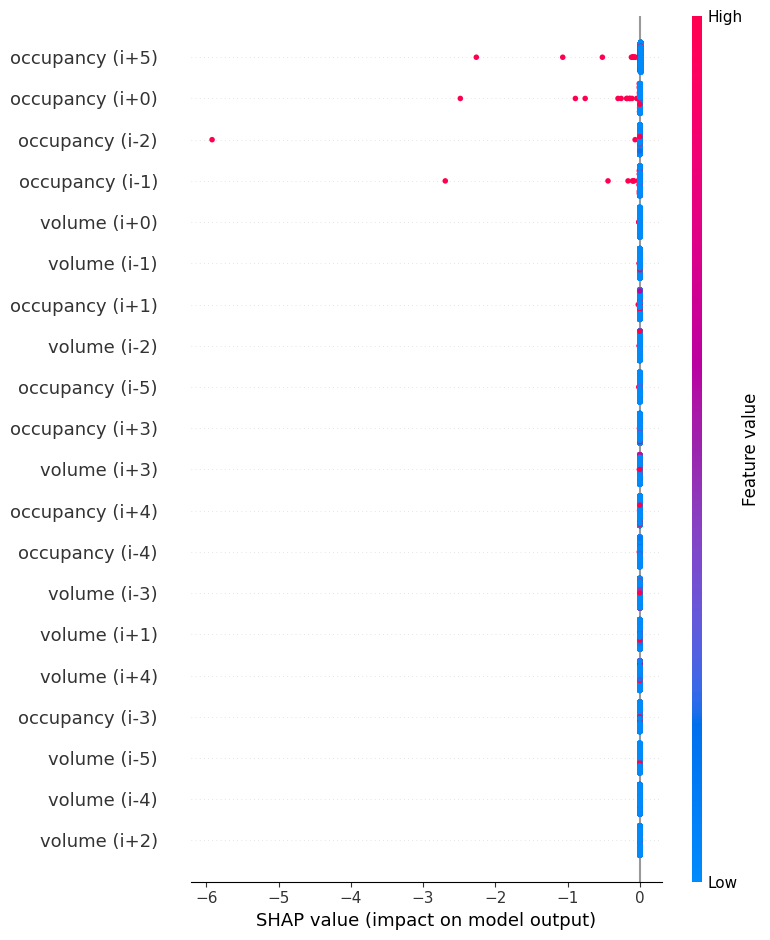

In [15]:
classifier.plot_shap_values(results) 

In [16]:
# Results summary
classifier.generate_summary_table(results)

,Setting,Model,DR,FAR,AUC-ROC,AUC-PR
0,Setting 1,Logistic Regression,0.27 (0.33)/0.17,0.23 (0.32)/0.03,0.53 (0.12)/0.52,0.04 (0.05)/0.01
1,Setting 1,Random Forest,0.12 (0.14)/0.17,0.12 (0.14)/0.07,0.49 (0.12)/0.49,0.03 (0.05)/0.01
2,Setting 1,XGBoost,0.19 (0.17)/0.17,0.19 (0.14)/0.14,0.48 (0.13)/0.47,0.02 (0.04)/0.01
3,Setting 2,Logistic Regression,0.22 (0.29)/0.17,0.18 (0.27)/0.04,0.54 (0.11)/0.54,0.04 (0.06)/0.01
4,Setting 2,Random Forest,0.11 (0.14)/0.00,0.11 (0.12)/0.07,0.51 (0.11)/0.51,0.03 (0.04)/0.01
5,Setting 2,XGBoost,0.17 (0.17)/0.17,0.17 (0.12)/0.14,0.49 (0.12)/0.48,0.01 (0.03)/0.01
